## Mathematical Formulation

$min_{\gamma,w,b} \frac{1}{2} \vert\vert w \vert\vert ^{2} + C \sum_{i=1}^{m} \xi_{i}$

$min_{\gamma,w,b} \frac{1}{2} \vert\vert w \vert\vert ^{2} + C 1^T\xi$

$ s.t.$ 

$ y^{(i)}(w^T x^{(i)} + b) \geq 1 - \xi_{i} , i=1,2,...m $

$ \xi_{i} \geq 0 , i=1,2,...m $

$ max_\alpha \sum_{i=1}^{m} \alpha_{i} - \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)}y^{(j)}\alpha_{i}\alpha_{j}<x^{(i)},x^{(j)}>$

$ s.t.$ 

$ 0 \leq \alpha_{i} \leq C_{i}, i=1,2,...m $

$  \sum_{i=1}^{m} \alpha_{i} y^{(i)} = 0 $

### Importing Libraries

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time, os

### Generating Data

In [3]:
DIM = 2
COLORS = ['red', 'blue']

# 2-D mean of ones
M1 = np.ones((DIM,))
# 2-D mean of threes
M2 = 2 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((DIM,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

NUM = 50
if __name__ == '__main__':
    # generate 50 points from gaussian 1
    x1 = generate_gaussian(M1, C1, NUM)
    x1_test = generate_gaussian(M1,C1,int(NUM/2))
    # labels
    y1 = np.ones((x1.shape[0],))
    y1_test = np.ones((int(x1_test.shape[0]),))
    # generate 50 points from gaussian 2
    x2 = generate_gaussian(M2, C2, NUM)
    x2_test = generate_gaussian(M2,C2,int(NUM/2))
    y2 = -np.ones((x2.shape[0],))
    y2_test = -np.ones((int(x2_test.shape[0]),))
    # join
    x = np.concatenate((x1, x2), axis = 0)
    y = np.concatenate((y1, y2), axis = 0)
    x_test = np.concatenate((x1_test,x2_test),axis = 0)
    y_test = np.concatenate((y1_test,y2_test),axis = 0)
    print('x {} y {}'.format(x.shape, y.shape))
    print('x_test {} y_test {}'.format(x_test.shape, y_test.shape))
    # write
    #with open('gaussiandata.pickle', 'wb') as f:
    #    pickle.dump((x, y), f)

x (100, 2) y (100,)
x_test (50, 2) y_test (50,)


### Plotting Functions

In [4]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

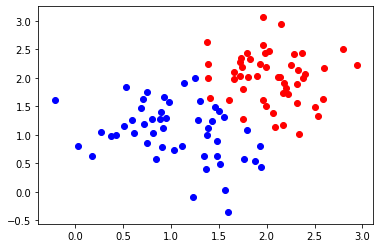

In [5]:
plot_data_with_labels(x, y)

In [6]:
def plot_separator(ax, w, b): 
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    minpt = np.min(x[:,0])
    maxpt = np.max(x[:,0])
    sep_min = minpt*slope+intercept
    sep_max = maxpt*slope+intercept
    ax.plot([minpt,maxpt], [sep_min,sep_max], 'k-')

In [7]:
def plot_margins(ax, w, b):
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    minpt = np.min(x[:,0])
    maxpt = np.max(x[:,0])
    margin_up_min = slope*minpt+intercept+1/w[1]
    margin_up_max = slope*maxpt+intercept+1/w[1]
    margin_down_min = slope*minpt+intercept-1/w[1]
    margin_down_max = slope*maxpt+intercept-1/w[1]
    
    ax.plot([minpt,maxpt],[margin_up_min,margin_up_max],'--',color='gray')
    ax.plot([minpt,maxpt],[margin_down_min,margin_down_max],'--',color='gray')

### Calculating the Support Vectors

In [68]:
def get_support_vectors(w,b,x):
    sv = []
    for i in range(x.shape[0]):
        if np.abs(np.abs(np.dot(w.T,x[i])+b)-1)<0.001:
            sv.append(x[i])
    return sv

# Primal

### Declaring Variables and Parameters

In [8]:
w = cp.Variable(DIM)
b = cp.Variable()
Xi = cp.Variable(2*NUM) #Length equal to total number of samples

Cp = cp.Parameter()
Cp.value = 0.6

### Declaring the Constraints

In [9]:
x_constraints = [y[i]*(w.T@x[i]+b) >= 1 - Xi[i] for i in range(2*NUM)]
Xi_constraints = [Xi[i]>=0 for i in range(2*NUM)]

constraints = x_constraints + Xi_constraints

### Declaring the Objective Function

In [10]:
objective = cp.Minimize(0.5*cp.norm(w,2)+Cp*(np.ones(2*NUM)@Xi))

### Declaring the Problem instance

In [11]:
prob = cp.Problem(objective,constraints)

### Final nail!!!

In [12]:
optimal_w = None
optimal_b = None

Cp.value = 0.95
stime = time.time()
prob.solve()

optimal_w = w.value
optimal_b = b.value

print("Problem Status : "+prob.status)
print("Objective Function Value : ",prob.value)
print("Time Taken : ",time.time()-stime," seconds\n")

Problem Status : optimal
Objective Function Value :  8.122560733999256
Time Taken :  0.4767262935638428  seconds



In [13]:
print("Optimal Value of w : ",optimal_w)
print("Optimal Value of b : ",optimal_b)

Optimal Value of w :  [-5.28903969 -3.9230688 ]
Optimal Value of b :  14.503911264673919


In [14]:
print("Training Accuracy : ",end=" ")
print(np.count_nonzero([y[i]*(w.value@x[i,:].T+b.value)>=0 for i in range(2*NUM)])/(2*NUM))

Training Accuracy :  0.98


In [15]:
print("Test Accuracy : ")
print(np.count_nonzero([y_test[i]*(w.value@x_test[i,:].T+b.value)>=0 for i in range(NUM)])/int(NUM))

Test Accuracy : 
0.96


In [69]:
support_vectors = np.array(get_support_vectors(optimal_w,optimal_b,x))

In [70]:
support_vectors

array([[1.14107537, 1.90379489],
       [1.50388369, 1.41466056],
       [2.08469206, 1.14142587]])

In [71]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

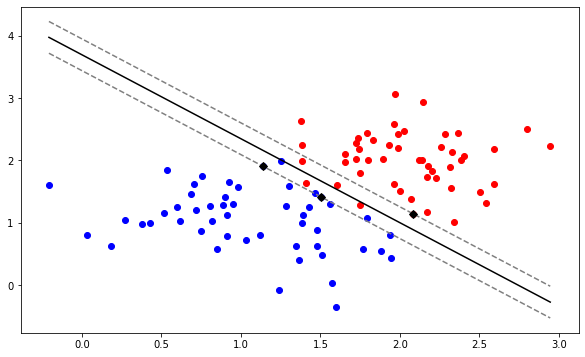

In [73]:
# show data and w
fig, ax = plt.subplots()
fig.set_size_inches((10,6))
plot_separator(ax, optimal_w, optimal_b)
plot_margins(ax,optimal_w,optimal_b)
ax.plot(support_vectors[:,0],support_vectors[:,1],'kD')
plot_data_with_labels(x, y, ax)

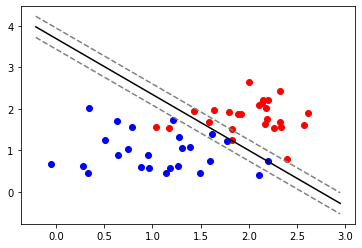

In [46]:
fig, ax = plt.subplots()
plot_separator(ax, optimal_w, optimal_b)
plot_margins(ax,optimal_w,optimal_b)
plot_data_with_labels(x_test, y_test, ax)
plt.show()

In [17]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from sklearn import svm

clf = svm.SVC(kernel='linear',C=1-0.05)
clf.fit(x,y)

SVC(C=0.95, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
print(clf.coef_[0],clf.intercept_)

[-1.69314349 -1.58813166] [4.96198224]


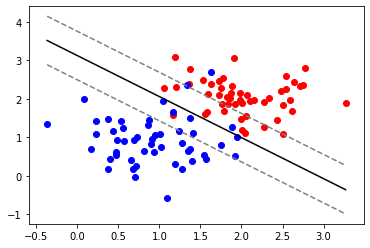

In [19]:
w1 = clf.coef_[0]
b1 = clf.intercept_
fig1, ax1 = plt.subplots()
plot_separator(ax1,w1,b1)
plot_margins(ax1,w1,b1)
plot_data_with_labels(x, y, ax1)
plt.show()

In [20]:
print("Training Accuracy: ", clf.score(x,y))

Training Accuracy:  0.96


In [21]:
clf.score(x_test,y_test)

0.94

#### It is evident that the result obtained using cvxpy is almost same as returned by sklearn.svm.SVC 

# Dual

In [232]:
def get_weights_and_bias(alphas):
    # get weights
    w = np.sum(alphas.value @ y[:, None] * x, axis = 0)
    # get bias
    cond = (alphas.value > 1e-4).reshape(-1)
    b = y[cond] - np.dot(x[cond], w)
    bias = b[0]
    return (w,bias)

In [170]:
alphas = cp.Variable(2*NUM)
Cd = cp.Parameter()
Cd.value = 0.95

In [171]:
alphas_constraint_1 = [alphas[i] >= 0 for i in range(2*NUM)]
alphas_constraint_2 = [alphas[i] <= Cd for i in range(2*NUM)]
alpha_y_constraint = [alphas.T@y==0]

constraints_dual = alphas_constraint_1 + alphas_constraint_2 + alpha_y_constraint

In [206]:
K = y[:,None]*x
K = np.dot(K,K.T)
#alpha_y = cp.multiply(y[:,None],alphas)
print(K)

[[ 1.83491803  1.75045974  2.28622267 ... -4.39732493 -5.00052443
  -3.77439719]
 [ 1.75045974  2.34203535  2.34179792 ... -5.44176538 -5.89979043
  -4.35890149]
 [ 2.28622267  2.34179792  2.8869991  ... -5.77716101 -6.50063002
  -4.88412578]
 ...
 [-4.39732493 -5.44176538 -5.77716101 ... 12.85096644 14.07871791
  10.45176273]
 [-5.00052443 -5.89979043 -6.50063002 ... 14.07871791 15.52527056
  11.56008668]
 [-3.77439719 -4.35890149 -4.88412578 ... 10.45176273 11.56008668
   8.61922173]]


In [282]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [285]:
is_pos_def(np.dot(K,K.T))

False

$min f(x) = q^T x + \frac{1}{2} x^T Q x$

$s.t.    Ax=a$

$Bx \leq b$

$x \geq 0$

If the objective function is convex, then any local minimum found is also the sole global minimum. To analyze the function’s convexity, one can compute its Hessian matrix and verify that all eigenvalues are positive, or, equivalently, one can verify that the matrix Q is positive definite

For SVM probelms having indefinite Kernels, refer to these papers
https://papers.nips.cc/paper/3339-support-vector-machine-classification-with-indefinite-kernels.pdf
http://icml2008.cs.helsinki.fi/papers/531.pdf

In [287]:
np.min(np.linalg.eigvals(K))

(-8.024450571441607e-15-5.444335439633958e-15j)

#### Complex Eigenvalues
For SVM problems having Kernels with complex eigenvalues, refer to 
https://res.mdpi.com/d_attachment/applsci/applsci-09-03090/article_deploy/applsci-09-03090.pdf

As is evident from results below, conventional methods of solving quadratic optimization problem gives incorrect results.

In [207]:
print(K.shape)
print(alphas.shape)

(100, 100)
(100,)


In [276]:
expr1 = cp.sum(alphas)
expr2 = 0.5*cp.sum_squares(alphas.T@K)

In [277]:
print(expr1.curvature,expr1.sign,expr1.is_dcp())
print(expr2.curvature,expr2.sign,expr2.is_dcp())

AFFINE UNKNOWN True
CONVEX NONNEGATIVE True


In [278]:
objective_dual = cp.Maximize(expr1-expr2)

In [279]:
prob_dual = cp.Problem(objective_dual,constraints)

In [290]:
cp.installed_solvers()

['ECOS', 'ECOS_BB', 'OSQP', 'SCS']

In [292]:
optimal_w = None
optimal_b = None

Cd.value = 0.6
stime = time.time()
prob_dual.solve(solver=cp.ECOS_BB)
print("Problem Status : "+prob_dual.status)
print("Objective Function Value : ",prob_dual.value)
print("Time Taken : ",time.time()-stime," seconds\n")

Problem Status : optimal
Objective Function Value :  12.598629209742224
Time Taken :  0.20547795295715332  seconds



In [293]:
print(alphas.value)

[ 6.00000000e-01  1.14376282e-12 -1.42320742e-12  6.00000000e-01
  1.06622077e-11 -3.50965859e-12 -2.27521624e-12 -6.22738101e-13
  2.15791013e-11 -1.50161328e-12 -1.63495682e-13  4.15987315e-02
 -1.41671973e-12  7.57382378e-13 -2.13767510e-12  2.95435134e-12
 -2.05555792e-12 -1.74532346e-12 -2.38102667e-12 -2.38603572e-12
 -2.30345060e-12 -4.35215169e-13 -2.41794939e-12  3.61847772e-11
  6.00000000e-01  6.00000000e-01  1.11549175e-12  3.00086823e-11
  4.34952009e-13  2.63457297e-01 -1.32363780e-12 -1.89976020e-12
  6.00000000e-01  8.99688500e-12  6.00000000e-01 -2.02484225e-12
  6.53379450e-12 -6.35872014e-13 -1.71153212e-12 -1.65410393e-12
  6.00000000e-01  6.00000000e-01  3.39435932e-13 -1.91371482e-12
  4.86798143e-12  8.38139949e-11  6.00000000e-01  2.03087837e-12
  6.00000000e-01 -2.47923645e-12  6.00000000e-01  1.60431989e-13
  4.64090176e-15 -9.49574143e-14  1.36940343e-13  7.83582647e-13
  3.33643475e-12  2.68157620e-13  1.54499382e-13 -7.41869731e-14
 -1.09527215e-12  6.00000

In [294]:
optimal_w,optimal_b = get_weights_and_bias(alphas)
print("Optimal Value of w : ",optimal_w)
print("Optimal Value of b : ",optimal_b)

Optimal Value of w :  [-5.89798172e-13 -5.13084024e-13]
Optimal Value of b :  1.0000000000015616


In [295]:
print("Training Accuracy : ",end=" ")
print(np.count_nonzero([y[i]*(optimal_w*x[i,:].T+optimal_b)>=0 for i in range(2*NUM)])/(2*NUM))

Training Accuracy :  1.0


In [296]:
print("Test Accuracy : ")
print(np.count_nonzero([y_test[i]*(optimal_w*x_test[i,:].T+optimal_b)>=0 for i in range(NUM)])/NUM)

Test Accuracy : 
1.0


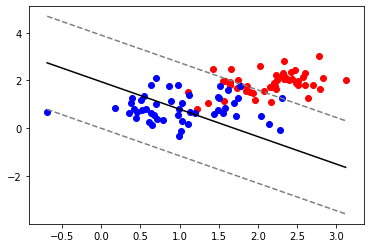

In [297]:
# show data and w
fig, ax = plt.subplots()
plot_separator(ax, 1e12*optimal_w, optimal_b)
plot_margins(ax,1e12*optimal_w,optimal_b)
plot_data_with_labels(x, y, ax)
plt.show()

### As can be clearly seen, unlike the PRIMAL case, the hyperplane is not correct.